In [177]:
import numpy as np                          # library to support matrix computations
import pandas as pd                         # library for data manipulation and analysis
import json
from os import listdir
import re
from scipy.linalg import eig                # linear algebra functions
import matplotlib.pyplot as plt
from string import ascii_uppercase
import unidecode
from pprint import pprint


In [178]:
def pca(X):
    ''' Principal Components Analysis '''
    cov_matrix = np.cov(X.T) # Transpose b/c np.cov assumes row vars.
    evals, evecs = eig(cov_matrix)
    idcs = np.argsort(evals)[::-1]
    evecs = evecs.real[:, idcs]
    evals = evals.real[idcs]

    return evecs, evals

In [179]:
def to_slug(x):
    return x.lower().replace(' ','_')


In [180]:
def preprocess(df):

    old_vals = ['Strongly Disagree',
                'Disagree',
                'Uncertain',
                'Agree',
                'Strongly Agree',
                'No Opinion',
                'Did Not Answer',
                'Did Not Vote',
                'Did not answer',
                None]
    new_vals = [-1.5,
                -1,
                0,
                1,
                1.5,
                np.nan,
                np.nan,
                np.nan,
                np.nan,
                np.nan]

    df = df.replace(old_vals, new_vals)

    # Only retain responders with > 75% response rate
    num_questions = len(df.columns)
    df = df[df.notnull().sum(axis=1) > (num_questions * 0.75)]

    # Replace remaining nans with the column mean
    df = df.fillna(df.mean())

    df = df.sort_index()
    return df

In [181]:
year = '2021'
survey_dir = 'surveys'

In [182]:
fnames_to_slugs = {
'2021-01-01-US-EEP-Bah-Humbug.csv':'bah-humbug',
'2021-01-01-US-EEP-Balanced-Budget-Amendment.csv':'balanced-budget-amendment',
'2021-01-01-US-EEP-Baumols-Cost-Disease.csv':'baumols-cost-disease',
'2021-01-01-US-EEP-Breaking-Up-Large-Tech-Companies.csv':'breaking-up-large-tech-companies',
'2021-01-01-US-EEP-College-Admissions.csv':'college-admissions'
}

In [183]:
fnames = sorted(fnames_to_slugs.keys())
qdfs = []
slugs = []
answers = {}
for fname in fnames:
    # pprint(survey_dir)
    qdf = pd.read_csv(survey_dir + '/' + fname)
    qdf = qdf.set_index(qdf['First Name'].str.cat(qdf['Last Name'], sep=' '))
    drop_columns = [col for col in qdf.columns if 'Confidence in this topic' in col or 'Please explain your' in col or 'Unnamed' in col]
    drop_columns += ['First Name', 'Last Name']
    qdf = qdf.drop(columns=drop_columns)
    qdf = qdf[qdf.index.notnull()]
    n_cols = len(qdf.columns)
    if n_cols > 1:
        qdf.columns = [f"Part {ascii_uppercase[i]}: {col}" for i, col in enumerate(qdf.columns)]
    qdfs += [qdf]
    for col in qdf.columns:
        slugs += [fnames_to_slugs[fname]]
df = pd.concat(qdfs, axis=1)
df.columns = [f"{i+1}. {col}" for i, col in enumerate(df.columns)]      # what does the final data strucutre look like?
print('-----')
pprint(df)
print('-----')
print(type(df))


-----
                   1. Giving specific presents as holiday gifts is inefficient, because recipients could satisfy their preferences much better with cash.  \
First Name                                                                                                                                                  
Daron Acemoglu1                                              Disagree                                                                                       
Alberto Alesina2                                    Strongly Disagree                                                                                       
Joseph Altonji3                                              Disagree                                                                                       
Alan Auerbach4                                              Uncertain                                                                                       
David Autor5                                        

In [189]:
df = preprocess(df)
# print(df.iloc[:,1].to_json())
# print(df.iloc[:, 0].to_json())
# df = df.replace(old_vals, slugs)
df2=df
df2.columns=slugs
df2.index = df2.index.map(to_slug)
# print(df2.index)
# df2=df2.transpose()
# print(df2.to_json())

Index(['alan_auerbach4', 'alberto_alesina2', 'daron_acemoglu1', 'david_autor5',
       'david_autor6', 'joseph_altonji3', 'katherine_baicker7'],
      dtype='object', name='First Name')


In [166]:
for slug in slugs:
    print(slug)

bah-humbug
balanced-budget-amendment
baumols-cost-disease
breaking-up-large-tech-companies
college-admissions


In [167]:
X_raw = np.array(df).astype(float)
q_means = X_raw.mean(axis=0)
q_sds = X_raw.std(axis=0)


In [168]:
# Separate responder IDs from row names
responder_ids = list(range(len(df)))

# Compute +/- 2SD for each question. For yellow highlights.
X_raw = np.array(df).astype(float)
q_means = X_raw.mean(axis=0)
q_sds = X_raw.std(axis=0)
igm_top_range =    2 * q_sds # Responses will be centered with q_means in .js
igm_bot_range = (-2) * q_sds # Responses will be centered with q_means in .js

# Centering the questions
X = X_raw - X_raw.mean(axis=0)

# Run PCA and compute 2D projection
evecs, evals = pca(X)

In [169]:
# Sign flipping so politically left is on the left
if year == '2021':
    evecs[:,0] = evecs[:,0] #X
    evecs[:,1] = -evecs[:,1]

# Compute each economists projection in 2D space.
proj = np.dot(X, evecs[:, 0:2])
print(proj)
# User info dict
user_info = {'name': 'You',
             'x': 0,
             'y': 0,
             'responder_id': 0}

[[ 1.0136163   0.03396907]
 [ 0.97787907  0.37691571]
 [ 0.35132514  1.12929269]
 [ 0.12855503 -0.77159051]
 [ 0.08000165 -2.04363819]
 [ 1.15535377  0.86160564]
 [-3.70673095  0.41344559]]


In [170]:
# Get correlation matrix, sorted by position on x-axis.
pc1_order = np.argsort(proj[:, 0])
corr_mat = np.corrcoef(X_raw[pc1_order, :])

# List of responder info dicts, including user dict
points = [user_info]
assert(len(df)==len(proj))
for i in range(len(proj)):
    responder_info = {'name': df.index[i],
                      'x': proj[i, 0],
                      'y': proj[i, 1],
                      'short_name': unidecode.unidecode(df.index[i].lower().replace(' ', '-')),
                      'pc1_order': int(np.argwhere(pc1_order == i))}
    points.append(responder_info)

In [171]:
out = {}
out['points'] = points
out['q_slugs'] = slugs
out['questions'] = [re.sub(r"\(0+", "(", col) for col in df.columns]
out['answers'] = df2.to_dict()
out['q_means'] = list(q_means)
out['xweights'] = list(evecs[:, 0])
out['yweights'] = list(evecs[:, 1])
out['X'] = [['%.2f' % el for el in row] for row in X.tolist()]
out['corr_mat'] = [['%.2f' % el for el in row]
                   for row in corr_mat.tolist()]
out['igm_top_range'] = ['%.2f' % el for el in igm_top_range]
out['igm_bot_range'] = ['%.2f' % el for el in igm_bot_range]

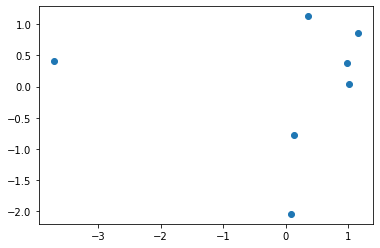

In [172]:
# Write to file
f = open("pca_results_test_" + year + ".json", "w")
json.dump(out, f, indent=2)
f.close()

# Plot responders in 2D space
plt.figure()
plt.scatter(proj[:, 0], proj[:, 1])
plt.show()